In [1]:
%set_env GPU=1
%set_env CL_DEVICE=-1
%set_env KOPT=1

env: GPU=1
env: CL_DEVICE=1
env: KOPT=1


In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tinygrad.tensor import Tensor
from tinygrad.nn import optim
from datasets import fetch_mnist
np.random.seed(1337)
Tensor.manual_seed(1337)

In [3]:
class Generator:
    def __init__(self, input_dim: int, output_dim: int):
        self.l1 = Tensor.scaled_uniform(input_dim, 256)
        self.l2 = Tensor.scaled_uniform(256, 512)
        self.l3 = Tensor.scaled_uniform(512, 1024)
        self.l4 = Tensor.scaled_uniform(1024, output_dim)
    
    def __call__(self, x: Tensor) -> Tensor:
        x = x.dot(self.l1).leakyrelu(0.2)
        x = x.dot(self.l2).leakyrelu(0.2)
        x = x.dot(self.l3).leakyrelu(0.2)
        x = x.dot(self.l4).tanh()
        return x

In [4]:
class Discriminator:
    def __init__(self, input_dim: int):
        self.l1 = Tensor.scaled_uniform(input_dim, 1024)
        self.l2 = Tensor.scaled_uniform(1024, 512)
        self.l3 = Tensor.scaled_uniform(512, 256)
        self.l4 = Tensor.scaled_uniform(256, 2)
    
    def __call__(self, x: Tensor) -> Tensor:
        x = x.dot(self.l1).leakyrelu(0.2).dropout(0.3)
        x = x.dot(self.l2).leakyrelu(0.2).dropout(0.3)
        x = x.dot(self.l3).leakyrelu(0.2).dropout(0.3)
        x = x.dot(self.l4).log_softmax()
        return x

In [5]:
batch_size = 512
epochs = 300
sample_interval = 50

real_images = np.vstack(fetch_mnist()[::2])
n_steps = len(real_images) // batch_size
ds_noise = Tensor(np.random.randn(20, 100), requires_grad=False)

generator = Generator(100, 784)
discriminator = Discriminator(784)
g_optim = optim.Adam(optim.get_parameters(generator), lr=0.0002, b1=0.5)
d_optim = optim.Adam(optim.get_parameters(discriminator), lr=0.0002, b1=0.5)

In [6]:
def make_batch(images: np.ndarray) -> Tensor:
    sample = np.random.randint(0, high=len(images), size=(batch_size))
    image_b = images[sample].reshape(-1, 28 * 28).astype(np.float32) / 255.0
    image_b = (image_b - 0.5) / 0.5
    return Tensor(image_b)

In [7]:
def make_labels(bs: int, value: int) -> Tensor:
    y = np.zeros((bs, 2), dtype=np.float32)
    y[range(bs), [value] * bs] = -2.0
    return Tensor(y)

In [8]:
def train_discriminator(optimizer: optim.Optimizer, real_data: Tensor, fake_data: Tensor) -> np.ndarray:
    real_labels = make_labels(batch_size, 1)
    fake_labels = make_labels(batch_size, 0)
    optimizer.zero_grad()
    real_output = discriminator(real_data)
    fake_output = discriminator(fake_data)
    real_loss = (real_output * real_labels).mean()
    fake_loss = (fake_output * fake_labels).mean()
    real_loss.backward()
    fake_loss.backward()
    optimizer.step()
    return (real_loss + fake_loss).cpu().numpy()

In [9]:
def train_generator(optimizer: optim.Optimizer, fake_data: Tensor) -> np.ndarray:
    real_labels = make_labels(batch_size, 1)
    optimizer.zero_grad()
    output = discriminator(fake_data)
    loss = (output * real_labels).mean()
    loss.backward()
    optimizer.step()
    return loss.cpu().numpy()

g_loss [0.6841444] d_loss [0.8825021]:  16%|█▋        | 49/300 [1:01:48<5:15:13, 75.35s/it] 

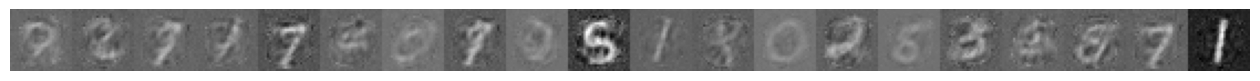

g_loss [0.6935616] d_loss [0.8450122]:  33%|███▎      | 99/300 [2:04:44<4:12:19, 75.32s/it]  

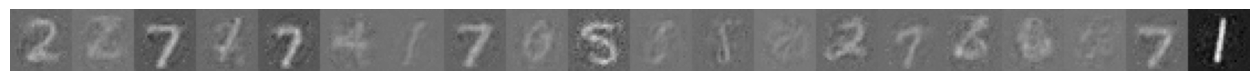

g_loss [0.70671755] d_loss [0.83708704]:  50%|████▉     | 149/300 [3:07:43<3:10:12, 75.58s/it]

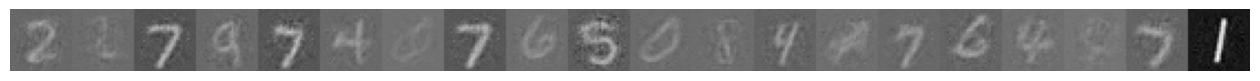

g_loss [0.701944] d_loss [0.83151335]:  66%|██████▋   | 199/300 [4:10:43<2:07:37, 75.81s/it]  

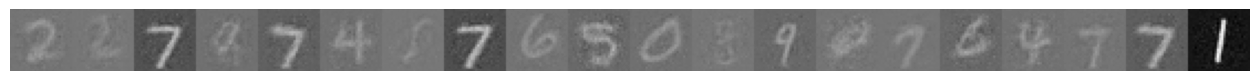

g_loss [0.7606414] d_loss [0.8079728]:  83%|████████▎ | 249/300 [5:13:42<1:04:19, 75.67s/it]  

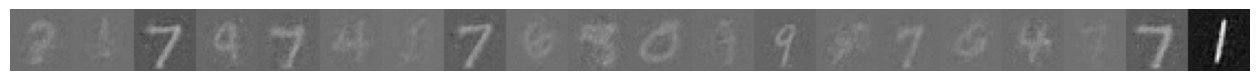

g_loss [0.69167316] d_loss [0.82983863]: 100%|█████████▉| 299/300 [6:16:43<01:15, 75.61s/it] 

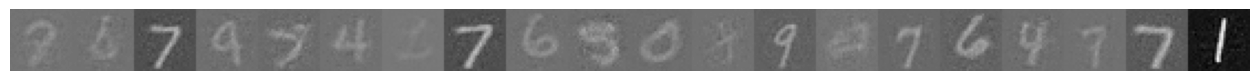

g_loss [0.69207287] d_loss [0.8341942]: 100%|██████████| 300/300 [6:17:59<00:00, 75.60s/it] 


In [10]:
for epoch in (t := trange(epochs)):
    g_loss, d_loss = 0.0, 0.0
    for _ in range(n_steps):
        Tensor.training = True
        real_data = make_batch(real_images)
        noise = Tensor(np.random.randn(batch_size, 100))
        d_loss += train_discriminator(d_optim, real_data, generator(noise).detach())
        noise = Tensor(np.random.randn(batch_size, 100))
        g_loss += train_generator(g_optim, generator(noise))
    if (epoch + 1) % sample_interval == 0:
        Tensor.training = False
        plt.figure(figsize=(16, 16))
        output = generator(ds_noise).detach().cpu().numpy()
        plt.imshow(np.hstack(output.reshape(-1, 28, 28)), cmap="gray")
        plt.axis("off")
        plt.show()
    t.set_description(f"g_loss {g_loss/n_steps} d_loss {d_loss/n_steps}")